In [2]:
import numpy as np
from floris.tools import FlorisInterface
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import re
from datetime import datetime

sns.set_theme()

In [3]:
surface_roughness = .7
measurement_height = 1.5
desired_height = 90

In [4]:
def logarithmic_function(surface_roughness: float, measurement_height: float, desired_height: float, velocity_at_measurement: float) -> float:
    return velocity_at_measurement * np.log(desired_height / surface_roughness) / np.log(measurement_height / surface_roughness)

Reading in the data from txt files. The txt files were found at https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/ and the location lander was chosen. It only reads data after the year 2013 because before that there was no wind data in the dataset

In [5]:
data = {}

parent_directory = './data/Lander'
data_directory = f'{parent_directory}/txtFiles'
pickle_directory = f'{parent_directory}/PickleDF'

if os.listdir(pickle_directory): # dataframe has been read in once and has been pickled
    for file_name in os.listdir(pickle_directory):
        year = re.findall(r'\d+', file_name)[0]
        data[year] = pd.read_pickle(f'{pickle_directory}/{file_name}')

else: # dataframe has never been read in before
    txt_directory = f'{parent_directory}/txtFiles'

    for file_name in os.listdir(f'{txt_directory}'):
        print(file_name)
        year = re.findall(r'\d+', file_name)[0]
        if int(year) < 2013:
            continue
        data[year] = pd.read_fwf(f"{txt_directory}/{file_name}", header=None, names=["WBANNO", "UTC_DATE", "UTC_TIME", "LST_DATE", "LST_TIME", "CRX_VN", "LONGITUDE", "LATITUDE", "AIR_TEMPERATURE", "PRECIPITATION", "SOLAR_RADIATION", "SR_FLAG", "SURFACE_TEMPERATURE", "ST_TYPE", "ST_FLAG", "RELATIVE_HUMIDITY", "RH_FLAG", "SOIL_MOISTURE_5", "SOIL_TEMPERATURE_5", "WETNESS", "WET_FLAG", "WIND_1_5", "WIND_FLAG"])

        data[year].replace(99.0, np.nan, inplace=True)

        data[year]["MeanWind90m"] = data[year].apply(lambda row : logarithmic_function(surface_roughness, measurement_height, desired_height, row["WIND_1_5"]), axis=1)

        data[year]["LST_TIME"] = data[year]["LST_TIME"].apply(lambda x: "{:04d}".format(x))

        data[year]["LST_TIME_COMBINED"] = data[year].apply(lambda row: f'{row["LST_DATE"]}{row["LST_TIME"]}', axis=1)

        data[year]["LST_TIME_COMBINED"] = pd.to_datetime(data[year]["LST_TIME_COMBINED"])

        data[year].to_pickle(f'{pickle_directory}/{file_name.split(".")[0]}.pkl')

Applying the logarithmic transformation on the data to obtain the theoretical wind speed at a height of 90m.

In [6]:
def resample_by( data:dict, sample_str: str = 'W-Mon', on: str = 'LST_TIME_COMBINED') -> dict:

    grouped_average = {}
    for year, df in data.items():
        y = data[year].resample(sample_str, label='left', closed = 'left', on=on).indices

        df = pd.DataFrame(columns=["Date", "MeanWind90m", "ID"])

        ID = 0

        for key,item in y.items():
            row = {
                'Date': key,
                'MeanWind90m': data[year].iloc[item]["MeanWind90m"].to_numpy(),
                'ID': ID
            }

            df = pd.concat([df, pd.DataFrame(row)], ignore_index=True)

            ID += 1

        grouped_average[year] = df

    return grouped_average


In [7]:
def plot_all_years(data: dict, x:str, y:str, estimator: str = 'mean'):
    for year, df in data.items():
        sns.lineplot(df, x=x, y=y, estimator=estimator, label=year)

In [8]:
weekly_average = resample_by(data)

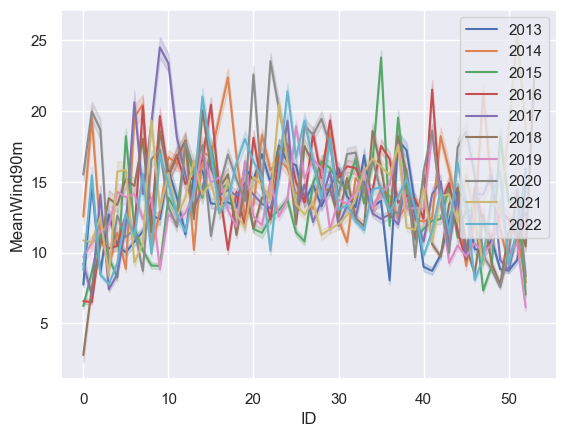

In [9]:
weekly_average = resample_by(data)
plot_all_years(weekly_average, "ID", "MeanWind90m", 'mean')


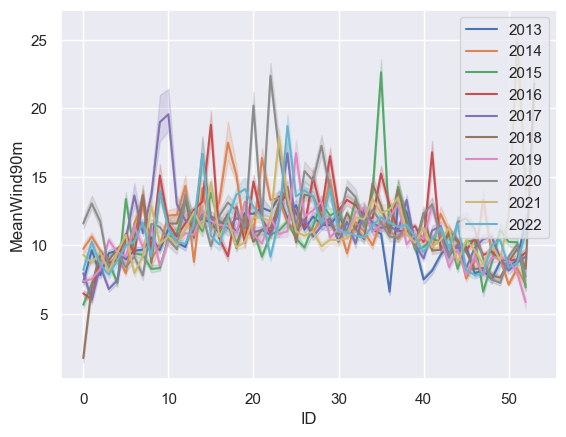

In [10]:
plot_all_years(weekly_average, "ID", "MeanWind90m", 'median')

In [11]:
weekly_average_combined = pd.DataFrame(columns=["Date", "MeanWind90m", "ID"])

for year, df in weekly_average.items():

    weekly_average_combined = pd.concat([weekly_average_combined, df], ignore_index=True)

<Axes: xlabel='ID', ylabel='MeanWind90m'>

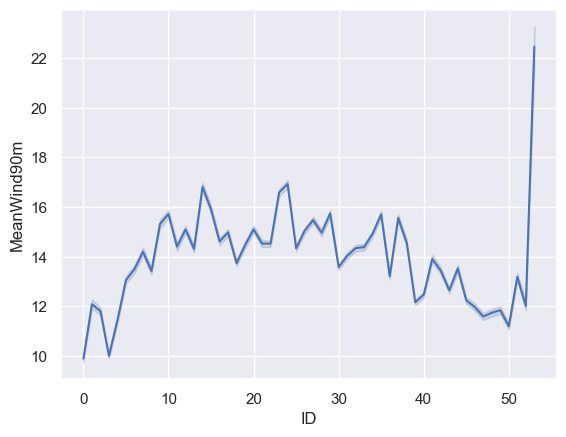

In [12]:
sns.lineplot(data=weekly_average_combined, x="ID", y="MeanWind90m")

<Axes: xlabel='ID', ylabel='MeanWind90m'>

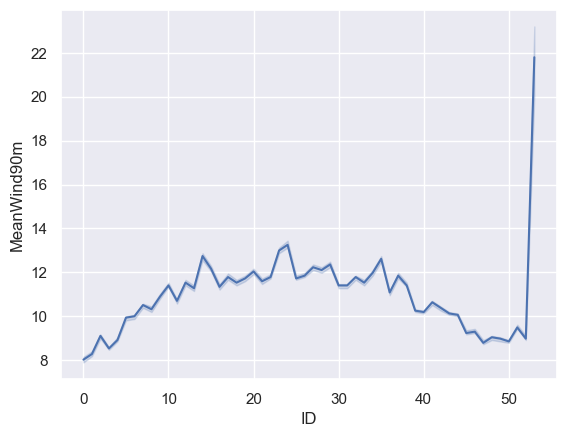

In [13]:
sns.lineplot(data=weekly_average_combined, x="ID", y="MeanWind90m", estimator='median')

In [14]:
monthly_average = resample_by(data, sample_str="M")

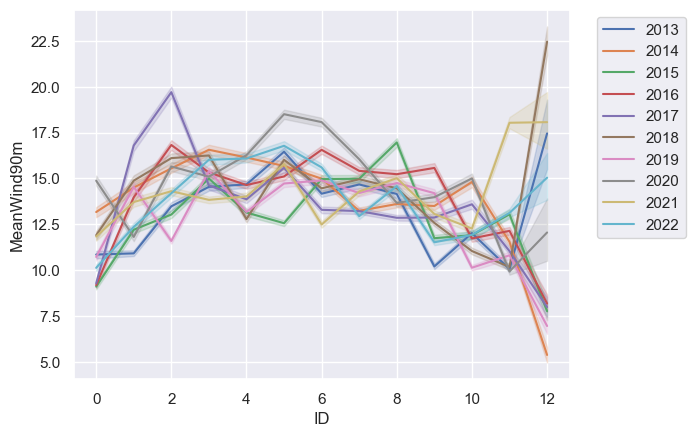

In [15]:
plot_all_years(monthly_average, 'ID', "MeanWind90m", 'mean')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

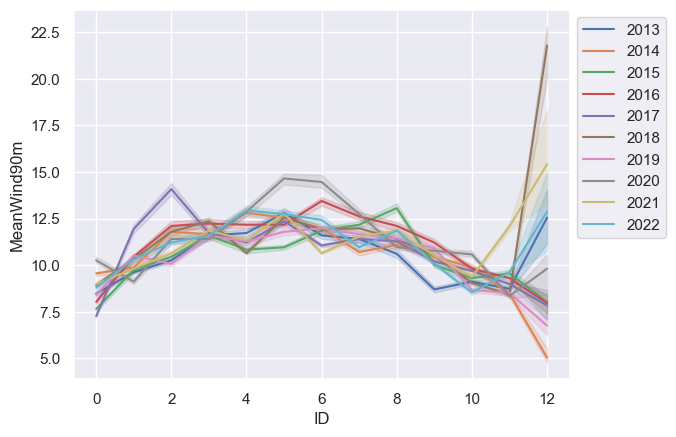

In [16]:
plot_all_years(monthly_average, 'ID', "MeanWind90m", 'median')
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")

In [17]:
daily_averages = resample_by(data=data, sample_str='D')

In [18]:
daily_averages['2013']['ID'].describe()

count     105120
unique       366
top          183
freq         288
Name: ID, dtype: int64

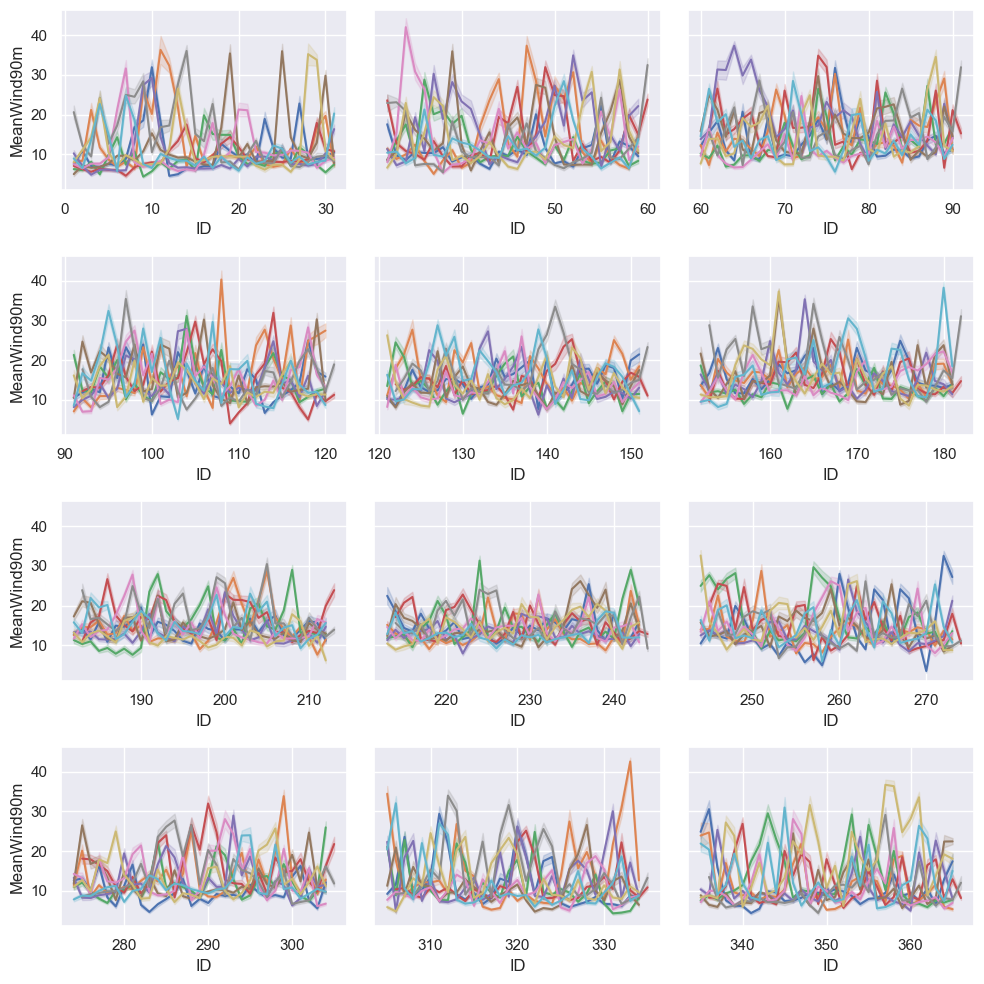

In [19]:
fig, ax = plt.subplots(4,3, sharey=True, figsize=(10,10))

ax = ax.ravel()

for month in range(1,13):
    for year, df in daily_averages.items():

        date_range = pd.Period(year=int(year), month=month, freq="M")
        df_slice = df.loc[(df['Date'] >= date_range.start_time) & (df['Date'] <= date_range.end_time)]

        sns.lineplot(df_slice, x='ID', y='MeanWind90m', ax=ax[month-1])


plt.tight_layout()

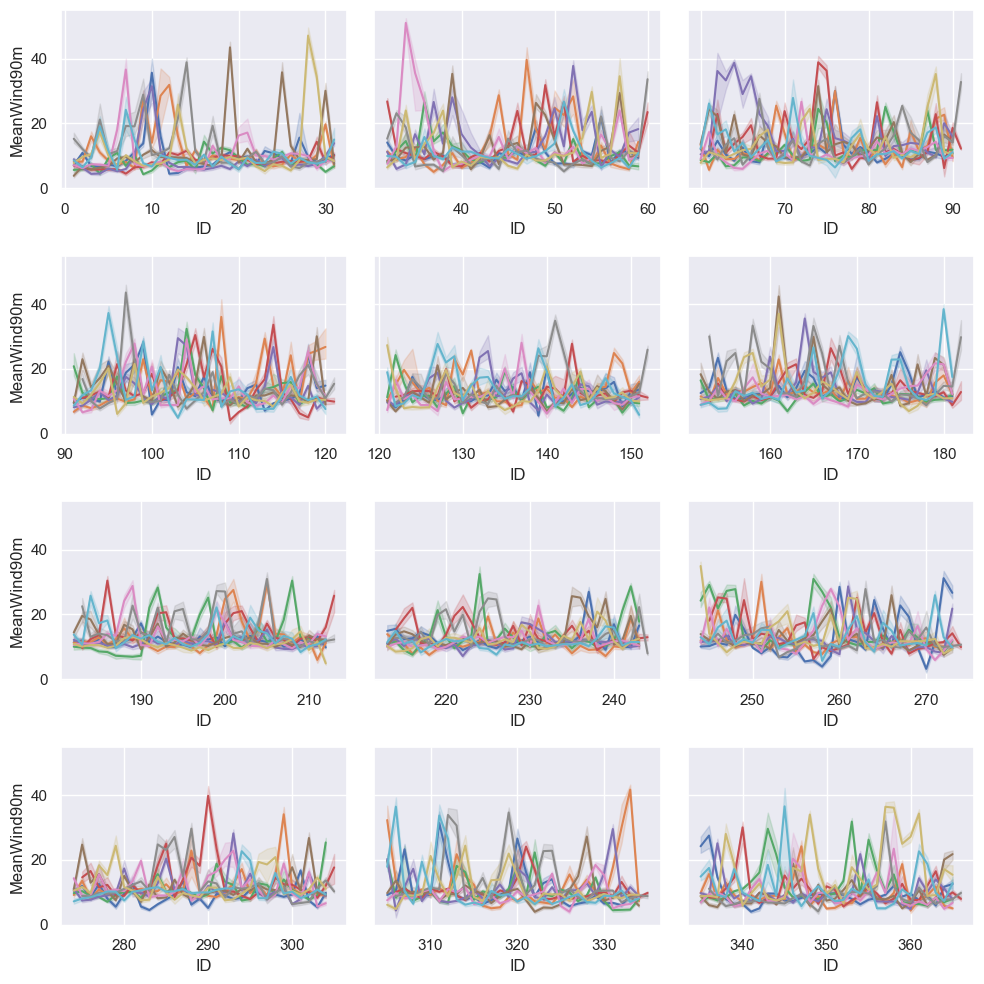

In [20]:
fig, ax = plt.subplots(4,3, sharey=True, figsize=(10,10))

ax = ax.ravel()

for month in range(1,13):
    for year, df in daily_averages.items():

        date_range = pd.Period(year=int(year), month=month, freq="M")
        df_slice = df.loc[(df['Date'] >= date_range.start_time) & (df['Date'] <= date_range.end_time)]

        sns.lineplot(df_slice, x='ID', y='MeanWind90m', ax=ax[month-1], estimator='median')

plt.tight_layout()